<a href="https://colab.research.google.com/github/plantions/published/blob/master/Emotion_Tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__Disclaimer__: Welcome to the Emotion Tracker developed in Collaboration with 
Prof. Peter Gloor and the support from Josephine Van Delden. This is an alpha version of the upcoming web service.

In [ ]:
#@title # Step 0: Upload Video

uploaded = files.upload()
for fn in uploaded.keys():
  print('Successfully uploaded file "{NAME_OF_UPLOADED_VIDEO}".'.format(
      NAME_OF_UPLOADED_VIDEO=fn,))

NAME_OF_UPLOADED_VIDEO = 'paprika.mov'
# NAME_OF_UPLOADED_VIDEO = '10s_silence.mov'
# NAME_OF_UPLOADED_VIDEO = 'hyper_tests.avi'

In [ ]:
#@title # Step 1: Choose Hyperparameters
# Clean up old files save new ones.
try:
    os.remove("pls_delete.mp4")
    os.remove("pls_delete.mpeg")
    os.remove("pls_delete.wav")
    os.remove("pls_delete_play.mp4")
except FileNotFoundError:
    print("Files already deleted.")
else:
    print("Files removed.")

INPUT_VIDEO = NAME_OF_UPLOADED_VIDEO

# Constants
INPUT_VIDEO_NAME = 'pls_delete'
OUTPUT_VIDEO_NAME_MPEG = 'pls_delete.mpeg'
OUTPUT_VIDEO_NAME_MP4 = '{}.mp4'.format(INPUT_VIDEO_NAME)
OUTPUT_VIDEO_NAME_WAV = '{}.wav'.format(INPUT_VIDEO_NAME)
FRAMES_PER_SECOND = 30

# Params
Interesting_Points =   2#@param {type:"integer"}
NO_OF_ROIS = (Interesting_Points-1)
Sound_Features =  4#@param {type:"integer"}
NO_OF_MFCC = Sound_Features
Shrink_Regions_by_px =  10#@param {type:"integer"}
ERODE_1 =  Shrink_Regions_by_px
ERODE_2 = ERODE_1 

# Dilate: Makes intersting regions grow.
Grow_Regions_by_px =  20#@param {type:"integer"}
DILATE_1 = Grow_Regions_by_px
DILATE_2 = DILATE_1

Lumen_Threshold = 127#@param {type:"integer"} 
MASK_THRESH = Lumen_Threshold
Countour_Approximation = 60#@param {type:"integer"}
CONTOUR_AREA = Countour_Approximation
OPENCV_MAJOR_VERSION = int(cv2.__version__.split('.')[0])

class Leaf():
    def __init__(self, id, hsv_frame, track_window):

        self.id = id

        self.track_window = track_window
        self.term_crit = \
            (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 10, 1)

        # Initialize the histogram.
        self.x, self.y, self.w, self.h = track_window
        roi = hsv_frame[y:y+h, x:x+w]
        roi_hist = cv2.calcHist([roi], [0], None, [16], [0, 180])
        self.roi_hist = cv2.normalize(roi_hist, roi_hist, 0, 255,
                                      cv2.NORM_MINMAX)

        # Initialize the Kalman filter.
        self.kalman = cv2.KalmanFilter(4, 2)
        self.kalman.measurementMatrix = np.array(
            [[1, 0, 0, 0],
             [0, 1, 0, 0]], np.float32)
        self.kalman.transitionMatrix = np.array(
            [[1, 0, 1, 0],
             [0, 1, 0, 1],
             [0, 0, 1, 0],
             [0, 0, 0, 1]], np.float32)
        self.kalman.processNoiseCov = np.array(
            [[1, 0, 0, 0],
             [0, 1, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1]], np.float32) * 0.03
        cx = x+w/2
        cy = y+h/2
        self.kalman.statePre = np.array(
            [[cx], [cy], [0], [0]], np.float32)
        self.kalman.statePost = np.array(
            [[cx], [cy], [0], [0]], np.float32)
        
    def get_plant_values(self): 
        return np.array([ self.id, self.x, self.y, self.w, self.h ])
    
    def update(self, frame, hsv_frame):

        back_proj = cv2.calcBackProject(
            [hsv_frame], [0], self.roi_hist, [0, 180], 1)

        ret, self.track_window = cv2.meanShift(
            back_proj, self.track_window, self.term_crit)
        x, y, w, h = self.track_window
        center = np.array([x+w/2, y+h/2], np.float32)

        prediction = self.kalman.predict()
        estimate = self.kalman.correct(center)
        center_offset = estimate[:,0][:2] - center
        self.track_window = (x + int(center_offset[0]),
                             y + int(center_offset[1]), w, h)
        x, y, w, h = self.track_window

        # Draw the predicted center position as a blue circle.
        cv2.circle(frame, (int(prediction[0]), int(prediction[1])),
                   4, (255, 0, 0), -1)

        # Draw the corrected tracking window as a cyan rectangle.
        cv2.rectangle(frame, (x,y), (x+w, y+h), (255, 255, 0), 2)

        # Draw the ID above the rectangle in blue text.
        cv2.putText(frame, 'ID: %d' % self.id, (x, y-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0),
                    1, cv2.LINE_AA)
        

Files already deleted.


In [ ]:
#@title # Step 2: Feature Engineering

print("Starting time: {}".format(datetime.now()))

# Create a VideoCapture object
import time
start_time = time.time()
cap = cv2.VideoCapture(INPUT_VIDEO)
arr = []
no_of_frame = 0

# Default resolutions of the frame are obtained and casted to int.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Create the KNN background subtractor.
bg_subtractor = cv2.createBackgroundSubtractorKNN()
history_length = 20
bg_subtractor.setHistory(history_length)

erode_kernel = cv2.getStructuringElement(
    cv2.MORPH_ELLIPSE, (ERODE_1, ERODE_2))
dilate_kernel = cv2.getStructuringElement(
    cv2.MORPH_ELLIPSE, (DILATE_1, DILATE_2))
leafs = []
num_history_frames_populated = 0

fourcc = cv2.VideoWriter_fourcc('M','P','E','G')
out = cv2.VideoWriter(OUTPUT_VIDEO_NAME_MPEG, fourcc, FRAMES_PER_SECOND, (frame_width,frame_height))

grabbed_frames = 0

while True:
    grabbed, frame = cap.read()
    grabbed_frames += 1
    # print(grabbed_frames)
    if (grabbed is False):
        break

    no_of_frame = no_of_frame + 1

    # Apply the KNN background subtractor.
    fg_mask = bg_subtractor.apply(frame)

    # Let the background subtractor build up a history.
    if num_history_frames_populated < history_length:
        num_history_frames_populated += 1
        continue

    # resources: https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html

    # Try this out:
    # th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
    #         cv.THRESH_BINARY,11,2)

    # Create the thresholded image.
    # MASK-Threshold
    _, thresh = cv2.threshold(fg_mask, MASK_THRESH, 255,
                                cv2.THRESH_BINARY)
    cv2.erode(thresh, erode_kernel, thresh, iterations=2)
    cv2.dilate(thresh, dilate_kernel, thresh, iterations=2)

    # Detect contours in the thresholded image.
    if OPENCV_MAJOR_VERSION >= 4:
        # OpenCV 4 or a later version is being used.
        contours, hier = cv2.findContours(
            thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else:
        _, contours, hier = cv2.findContours(
            thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Draw green rectangles around large contours.
    # Also, if no leafs are being tracked yet, create some.
    should_initialize_leafs = len(leafs) == 0
    id = 0
    for c in contours:
        if cv2.contourArea(c) > CONTOUR_AREA:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(frame, (x, y), (x+w, y+h),
                            (0, 255, 0), 1)
            if should_initialize_leafs:
                leafs.append(
                    Leaf(id, hsv_frame,
                                (x, y, w, h)))
        frame_no_and_values = np.array([ id, x, y, w, h ])
        a = np.append(frame_no_and_values, [no_of_frame])
        arr.append(a)
        id += 1
        

    # Update the tracking of each leaf.
    for leaf in leafs:
        leaf.update(frame, hsv_frame)
        frame_no_and_values = np.array([ id, x, y, w, h ])
        a = np.append(frame_no_and_values, [no_of_frame])
        arr.append(a)
    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()

motion_array = np.array(arr)
print("Processing took", round(((time.time() - start_time)/60), 2), "minutes.")

start_time2 = time.time()

# # To Do: shorten videos to maximal 20s, so that you can watch all of them.

# subprocess.run('ffmpeg -i {} {}'.format(OUTPUT_VIDEO_NAME_MPEG, OUTPUT_VIDEO_NAME_MP4), shell=True)

# from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
# ffmpeg_extract_subclip('pls_delete.mp4', 0, 10, targetname="pls_delete_play.mp4")

# print("Conversion to mp4 and creating preview took", round(((time.time() - start_time2)/60), 2), "minutes.")

Starting time: 2020-06-16 14:23:34.259380
Processing took 2.11 minutes.


In [ ]:
# @title #Step 3: Preview the Video

def playvideo(filename):
    video = io.open(filename, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video width="80%" style="display:block; margin:0 auto;" alt="test" controls>
                    <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
                 </video>'''.format(encoded.decode('ascii')))
playvideo('pls_delete_play.mp4')


In [ ]:
# @title # Step 4: Data Visualizations

# ____ VIDEO PROCESSING ____
# This is the output NumPy Array from the video processing
data = motion_array

# Create a Pandas DataFrame from NumPy arrays with UniqueID, x- & y-Value of ROI (i.e., Region of Interest), as well as width and height of the accompanying moving windows. 
# Frame refers to video frame (30 fps) on which point was tracked.
# RESET DF
df_video = pd.DataFrame(data=data[0:,0:], index=[i for i in range(data.shape[0])], columns=['ID','X','Y','W','H','Frame'])

# Calculate Elapsed Time for Frames of Video
df_video["Elapsed"] = round(df_video["Frame"]/30, 1)

# Remove Duplicates
df_video_wo_dups = df_video.drop_duplicates(subset=None, keep='first', inplace=False)
df_video_queried = df_video_wo_dups.query('0 <= ID <= {}'.format(NO_OF_ROIS))
# df_video_4_cols = df_video_queried.filter(items=['ID', 'X', 'Y', 'Elapsed'])
df_video_3_cols = df_video_queried.filter(items=['ID', 'Y', 'Elapsed'])

# Minding that Matplotlib inverts x/y Values
# df_inverted_x_y_minus_1 = df_video_4_cols.sub([0, frame_width, frame_height, 0], axis='columns')
df_inverted_x_y_minus_1 = df_video_3_cols.sub([0, frame_height, 0], axis='columns')
# df_inverted_x_y = df_inverted_x_y_minus_1.mul([1, -1, -1, 1], axis='columns')
df_inverted_x_y = df_inverted_x_y_minus_1.mul([1, -1, 1], axis='columns')
df_video = df_inverted_x_y

# Use Pivot Feature of Pandas DataFrame
# df_pivoted_video = pd.pivot_table(df_video, values=["X", "Y"], index=pd.Grouper(key='Elapsed'), columns=["ID"],)
df_pivoted_video = pd.pivot_table(df_video, values=["Y"], index=pd.Grouper(key='Elapsed'), columns=["ID"],)

# Create flexible number of indices based on number of Regions of Interest
int(df_video_queried.max(axis = 0)[0]); counter = 0
# x_indices = []
y_indices = []
while counter <= int(df_video_queried.max(axis = 0)[0]):
    # x_indices.append(('X' + str(counter))); 
    y_indices.append(('Y' + str(counter)))
    counter = counter + 1
df_pivoted_video.columns = y_indices # + x_indices

# ____AUDIO PROCESSING____

# Extracts Audio from Input Video
command = "ffmpeg -i {} -ab 160k -ac 2 -ar 44100 -vn {}".format(INPUT_VIDEO, OUTPUT_VIDEO_NAME_WAV)
subprocess.call(command, shell=True)

# Unpack Audio
audio_path = INPUT_VIDEO
x , sr = librosa.load(audio_path)

# Get the MFCCs (and choose the number of features to extract); manipulate Pandas DataFrame.
mfccs = librosa.feature.mfcc(x, sr=sr, n_mfcc=NO_OF_MFCC)
audio_data = np.transpose(mfccs)

# Calculate the step length between a mfcc and the audio in seconds
window_length = 512 # default value by mfcc algorithm
length = (round((window_length/sr)*mfccs.shape[1]), 2)
step_size = length[0]/mfccs.shape[1]

# Getting Elapsed Time of Audio from Audiofile
audio_time_data = np.arange(0, (length[0]), step_size)
audio_time_data = np.round(audio_time_data, 1)
df_audio_time_steps = pd.DataFrame(data=audio_time_data, 
                index=[i for i in range(audio_time_data.shape[0])], 
                columns=['Elapsed_t'])
# Create the Audio Pandas DataFrame
df_audio = pd.DataFrame(data=audio_data, 
                index=[i for i in range(audio_data.shape[0])], 
                columns=['MFCC'+str(i) for i in range(audio_data.shape[1])])
df_audio_w_time = pd.concat([df_audio_time_steps, df_audio], axis=1, join='outer')
df_audio_w_time_w_o_dups = df_audio_w_time.drop_duplicates(subset='Elapsed_t', keep='first')
df_audio_w_time_w_o_dups

## Merge AUDIO and VIDEO
# df_merged = pd.concat([df_audio_w_time_w_o_dups, df_pivoted_video], axis = 1, join= 'outer')
df_merged = pd.merge(df_audio_w_time_w_o_dups, df_pivoted_video, how='left', left_on=['Elapsed_t'], right_on=['Elapsed']) # add 'indicator=True' to see functionality
df_bf_filled = df_merged.fillna(method='bfill') # backward filling (NANs filling up)
df_filled = df_bf_filled.fillna(method='ffill') # forward filling (NANs filling down)

# transform from wide to long-form data
# https://altair-viz.github.io/user_guide/data.html

df_filled_every_two_seconds = df_filled.iloc[::20]

df_filled_melted = df_filled_every_two_seconds.melt('Elapsed_t', var_name='Variables', value_name='Values')

alt.Chart(df_filled_melted).mark_line().encode(
  x='Elapsed_t',
  y='Values',
  color='Variables'
  ).properties(
    width=900,
    height=400,
).interactive(bind_y=False)

alt.Chart(...)

This plant observed that the speaker is >>> happy <<<.


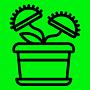

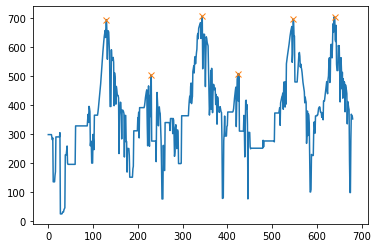

In [ ]:
# @title # Step 5: Happiness Indicator

total_happiness_counter = 0
per_curve_happiness_counter = 0
img_happy = cv2.imread('happy.png', cv2.IMREAD_UNCHANGED)
img_sad = cv2.imread('sad.png', cv2.IMREAD_UNCHANGED)

# obviously one cannot assume that the height is fixed
HEIGHT = 400
# HEIGHT = (max(x[peaks])/2 )

# To Do: has to be a regex and start with y(i) values
for tracked_move in df_filled.columns[5:]:
    x = df_filled[tracked_move]
    # try without height bc its an absolute value
    peaks, _ = find_peaks(x, HEIGHT, distance=50)
    per_curve_happiness_counter = 0
    per_curve_happiness_indicators = len(x[peaks])
    happiness_threshold = (max(x[peaks]) + min(x[peaks]))/2
    
    for value in x[peaks]:
        if value > happiness_threshold:
            per_curve_happiness_counter = per_curve_happiness_counter + 1
            total_happiness_counter = total_happiness_counter + 1

if per_curve_happiness_counter > (per_curve_happiness_indicators/2):
    print("This plant observed that the speaker is >>> happy <<<.")
    cv2_imshow(img_happy)
else:
    print("This plant observed that the speaker is >>> sad <<<.")
    cv2_imshow(img_sad)

plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.show()    

# Additional Features

This plant observed that the speaker is >>> sad <<<.


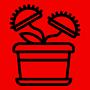

In [ ]:
# @title ## Dummy Sad Plant

img_happy = cv2.imread('happy.png', cv2.IMREAD_UNCHANGED)
img_sad = cv2.imread('sad.png', cv2.IMREAD_UNCHANGED)
print("This plant observed that the speaker is >>> sad <<<.")
cv2_imshow(img_sad)

<IPython.core.display.Javascript object>

Saved to photo.jpg


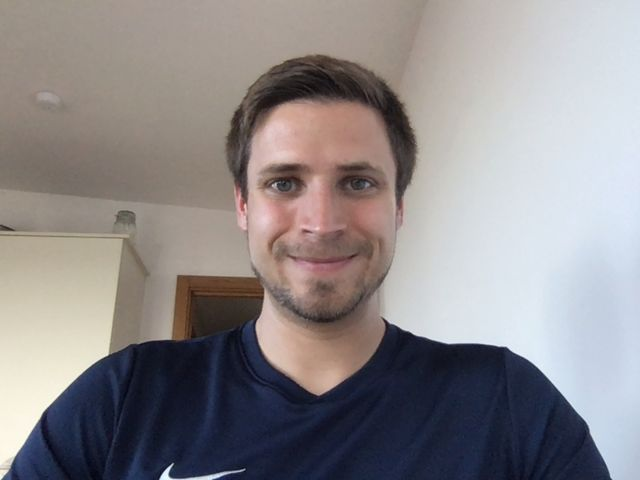

In [ ]:
# @title ## Camera Capturing [in Process]

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# @title ## Export to Excel
df_filled.to_excel('11_min_video.xlsx')
df_filled_melted.to_excel('11_min_video_melted.xlsx')

In [ ]:
# @title ## Interactive Scatter Plot

# df_filled

# alt.Chart(df_filled_melted).mark_circle().encode(
#     alt.X(alt.repeat("column"), type='quantitative'),
#     alt.Y(alt.repeat("row"), type='quantitative'),
# ).properties(
#     width=150,
#     height=150
# ).repeat(
#     row=['Elapsed_t', 'Variables', 'Values'],
#     column=['Variables', 'Elapsed_t', 'Values']
# ).interactive()

In [ ]:
# @title ## Check for Movie Duration
import moviepy.editor

# Converts into more readable format
def convert(seconds):
    hours = seconds // 3600
    seconds %= 3600

    mins = seconds // 60
    seconds %= 60

    return hours, mins, seconds

# Duration of Input Video
video = moviepy.editor.VideoFileClip(INPUT_VIDEO)
video_duration = float(video.duration)
hours, mins, secs = convert(video_duration)
print("The Video named {} Seconds:".format(INPUT_VIDEO), secs)

# Duration of Resulting Video
video2 = moviepy.editor.VideoFileClip(OUTPUT_VIDEO_NAME_MP4)
video_duration2 = float(video2.duration)
hours, mins, secs = convert(video_duration2)
print("The Video named {} Seconds:".format(OUTPUT_VIDEO_NAME_MP4), secs)

# Cross-check Length of Video and Audio
print("Length of Audio in Seconds: ", (512/sr)*mfccs.shape[1])

In [ ]:
# @title ## Getting FPS of Video

#!/usr/bin/env python

import cv2
import time

if __name__ == '__main__' :

    # Start default camera
    video = cv2.VideoCapture(INPUT_VIDEO)

    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

    # Release video
    video.release()

In [ ]:
#@title ## Download Video via GitHub

# Imports
from google.colab import files
import ipywidgets as widgets
from IPython.display import HTML
from IPython.display import display
from IPython.display import clear_output
from datetime import datetime
import cv2
import numpy as np
import pandas as pd
import subprocess
import io
import os
import base64
import librosa
import librosa.display
import altair as alt
from scipy.signal import chirp, find_peaks, peak_widths
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
!curl -o happy.png https://i.imgur.com/PXpWO5Cs.png
!curl -o sad.png https://i.imgur.com/mAYh4Qts.png
!curl -o paprika_lq.mov https://github.com/plantions/published/blob/master/paprika_lq.mov
!curl -o paprika.mov https://github.com/plantions/published/blob/master/paprika.mov

# uploaded = files.upload()
# for fn in uploaded.keys():
#   print('Successfully uploaded file "{NAME_OF_UPLOADED_VIDEO}".'.format(
#       NAME_OF_UPLOADED_VIDEO=fn,))

# NAME_OF_UPLOADED_VIDEO = fn
# # NAME_OF_UPLOADED_VIDEO = '10s_silence.mov'
# # NAME_OF_UPLOADED_VIDEO = 'hyper_tests.avi'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2850  100  2850    0     0  31666      0 --:--:-- --:--:-- --:--:-- 32022
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2326  100  2326    0     0  26431      0 --:--:-- --:--:-- --:--:-- 26134
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70704    0 70704    0     0   206k      0 --:--:-- --:--:-- --:--:--  206k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70648    0 70648    0     0   227k      0 --:--:-- --:--:-- --:--:--  226k


Please send Feedback to sduerr@mit.edu.